# MS026 Preprocess
06/28/2023

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS026'
subj_format = ['nlx']
subj_site = ['MSSM']


## Load raw nlx data 


In [12]:
load_path = f'{neural_dir}{subj_id}/raw_nlx/'
seeg_names = None
resp_names = None
ekg_names = None
eeg_names = None

In [13]:
### removing extraneous numbering from channel names 

# per Shawn, MSSM data seems to sometime have a "_0000.ncs" to "_9999.ncs" appended to the end of real data
pattern = re.compile(r"_\d{4}\.ncs")  # regex pattern to match "_0000.ncs" to "_9999.ncs"
ncs_files = [x for x in glob(f'{load_path}/*.ncs') if re.search(pattern, x)]
# just in case this changes in the future: 
if len(ncs_files) == 0: 
    ncs_files = glob(f'{load_path}/*.ncs')
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','') for x in glob(f'{load_path}/[R,L]*.ncs')]
else:
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','').split('_')[0] for x in glob(f'{load_path}/[R,L]*.ncs') if re.search(pattern, x)]

In [14]:
seeg_names = [x.lower() for x in seeg_names] 

In [15]:
### empty vecs to load data into 

signals = [] #data
srs = [] #sampling rate
ch_name = [] #channel name
ch_type = [] #channel type (seeg, eeg etc.)

In [16]:
for chan_path in ncs_files:
    chan_name = chan_path.split('/')[-1].replace('.ncs','')
    # strip the file type off the end if needed 
    if '_' in chan_name:
        chan_name = chan_name.split('_')[0]
    try:
        fdata = nlx_utils.load_ncs(chan_path)
    except IndexError: 
        print(f'No data in channel {chan_name}')
        continue
    if eeg_names:
        if chan_name.lower() in eeg_names:
            ch_type.append('eeg')
    if resp_names:
        if chan_name.lower() in resp_names:
            ch_type.append('bio')
    if ekg_names:
        if chan_name.lower() in ekg_names: 
            ch_type.append('ecg') 
    if seeg_names: 
        if chan_name.lower() in seeg_names:
            ch_type.append('seeg')  
        elif chan_name.lower()[0] == 'u':
            # microwire data
            ch_type.append('seeg')  
    signals.append(fdata['data'])
    srs.append(fdata['sampling_rate'])
    ch_name.append(chan_name)
    if len(ch_type) < len(ch_name):
        ch_type.append('misc')
        print(f'Unidentified data type in {chan_name}')

Unidentified data type in Photodiode


In [17]:
ch_name

['LHtOc1',
 'RHtOc5',
 'RaCaS8',
 'LCMsP9',
 'LCMsP8',
 'RaCaS9',
 'RHtOc4',
 'RHplT9',
 'LHtOc2',
 'RHtOc6',
 'RmCmS8',
 'RmCmS9',
 'RHtOc7',
 'LHtOc3',
 'RHplT8',
 'LHtOc7',
 'LmCmS9',
 'RHtOc3',
 'LHplT8',
 'LHplT9',
 'RHtOc2',
 'LmCmS8',
 'LHtOc6',
 'LHtOc4',
 'LaCaS9',
 'RCMsP8',
 'RHtOc1',
 'RCMsP9',
 'LaCaS8',
 'LHtOc5',
 'RAglT6',
 'LAglT2',
 'RmOlF9',
 'RmOlF8',
 'LAglT3',
 'RAglT7',
 'LHplT10',
 'RAglT5',
 'LAglT1',
 'RAglT4',
 'RHplT10',
 'LAglT4',
 'LAglT5',
 'RAglT1',
 'LmOlF8',
 'RAglT3',
 'LAglT7',
 'LAglT6',
 'RAglT2',
 'LmOlF9',
 'LmOlF4',
 'RaCaS10',
 'RCMsP16',
 'LCMsP13',
 'RmOlF1',
 'LCMsP12',
 'LaCaS14',
 'RaCaS11',
 'LmOlF5',
 'LmOlF7',
 'RaCaS13',
 'RCMsP15',
 'LCMsP10',
 'LAglT8',
 'RmOlF3',
 'RmOlF2',
 'LAglT9',
 'LCMsP11',
 'RCMsP14',
 'RaCaS12',
 'LmOlF6',
 'LmOlF2',
 'LaCaS13',
 'RCMsP10',
 'LCMsP15',
 'RAglT9',
 'RmOlF6',
 'RmOlF7',
 'RAglT8',
 'LCMsP14',
 'RCMsP11',
 'LaCaS12',
 'LmOlF3',
 'LmOlF1',
 'LaCaS10',
 'RCMsP13',
 'LCMsP16',
 'RmOlF5',
 'RmOlF4'

In [18]:
ch_names = list(ch_name)
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
print(probe_names)

['LAglT' 'LCMsP' 'LHplT' 'LHtOc' 'LaCaS' 'LmCmS' 'LmOlF' 'Photodiode'
 'RAglT' 'RCMsP' 'RHplT' 'RHtOc' 'RaCaS' 'RmCmS' 'RmOlF']


In [19]:
srs

[2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 32000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000

In [20]:
target_sr = 500 #downsampling to 500 to be consistent with other data - alternative = np.min(srs)
mne_data_resampled = []

In [21]:
### resampling to 500Hz

for sr in np.unique(srs):
    ch_ix = np.where(srs==sr)[0].astype(int)
    info = mne.create_info([x for ix, x in enumerate(ch_name) if ix in ch_ix], sr, [x for ix, x in enumerate(ch_type) if ix in ch_ix])
    mne_data_temp = mne.io.RawArray([x for ix, x in enumerate(signals) if ix in ch_ix], info)
    if sr != target_sr:
        # resample down to one sample rate 
        mne_data_temp.resample(sfreq=target_sr, npad='auto', n_jobs=-1)
        mne_data_resampled.append(mne_data_temp)
    else: 
        mne_data = mne_data_temp
        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   31.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   15.7s finished


In [36]:
### make sure timing is aligned post resampling --- check this 

#Because of the resampling, the end timings might not match perfectly:https://github.com/mne-tools/mne-python/issues/8257

if mne_data_resampled[1].tmax > mne_data_temp.tmax:
    mne_data_resampled[1].crop(tmin=0, tmax=mne_data_temp.tmax)
elif mne_data_resampled[1].tmax < mne_data_temp.tmax:
    mne_data_temp.crop(tmin=0, tmax=mne_data_resampled[1].tmax)
    

In [37]:

if mne_data_resampled[0].tmax > mne_data_temp.tmax:
    mne_data_resampled[0].crop(tmin=0, tmax=mne_data_temp.tmax)
elif mne_data_resampled[0].tmax < mne_data_temp.tmax:
    mne_data_temp.crop(tmin=0, tmax=mne_data_resampled[0].tmax)

In [45]:
mne_data_resampled[1].info['line_freq'] = mne_data_resampled[0].info['line_freq']

In [39]:
mne_data_resampled[1]

<RawArray | 1 x 1815856 (3631.7 s), ~13.9 MB, data loaded>

In [46]:
mne_data = mne_data_resampled[0]  #mne_data.add_channels([mne_data_temp]) to add more channels input mne object as list
mne_data.add_channels([mne_data_resampled[1]])
mne_data

<RawArray | 169 x 1815856 (3631.7 s), ~2.29 GB, data loaded>

In [47]:
#make channel names lowercase 
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawArray | 169 x 1815856 (3631.7 s), ~2.29 GB, data loaded>

## Notch filter line noise

In [48]:

mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:    6.1s finished


<RawArray | 169 x 1815856 (3631.7 s), ~2.29 GB, data loaded>

In [49]:
mne_data.ch_names

['lhtoc1',
 'rhtoc5',
 'racas8',
 'lcmsp9',
 'lcmsp8',
 'racas9',
 'rhtoc4',
 'rhplt9',
 'lhtoc2',
 'rhtoc6',
 'rmcms8',
 'rmcms9',
 'rhtoc7',
 'lhtoc3',
 'rhplt8',
 'lhtoc7',
 'lmcms9',
 'rhtoc3',
 'lhplt8',
 'lhplt9',
 'rhtoc2',
 'lmcms8',
 'lhtoc6',
 'lhtoc4',
 'lacas9',
 'rcmsp8',
 'rhtoc1',
 'rcmsp9',
 'lacas8',
 'lhtoc5',
 'raglt6',
 'laglt2',
 'rmolf9',
 'rmolf8',
 'laglt3',
 'raglt7',
 'lhplt10',
 'raglt5',
 'laglt1',
 'raglt4',
 'rhplt10',
 'laglt4',
 'laglt5',
 'raglt1',
 'lmolf8',
 'raglt3',
 'laglt7',
 'laglt6',
 'raglt2',
 'lmolf9',
 'lmolf4',
 'racas10',
 'rcmsp16',
 'lcmsp13',
 'rmolf1',
 'lcmsp12',
 'lacas14',
 'racas11',
 'lmolf5',
 'lmolf7',
 'racas13',
 'rcmsp15',
 'lcmsp10',
 'laglt8',
 'rmolf3',
 'rmolf2',
 'laglt9',
 'lcmsp11',
 'rcmsp14',
 'racas12',
 'lmolf6',
 'lmolf2',
 'lacas13',
 'rcmsp10',
 'lcmsp15',
 'raglt9',
 'rmolf6',
 'rmolf7',
 'raglt8',
 'lcmsp14',
 'rcmsp11',
 'lacas12',
 'lmolf3',
 'lmolf1',
 'lacas10',
 'rcmsp13',
 'lcmsp16',
 'rmolf5',
 'rmolf4'

## Examine photodiode

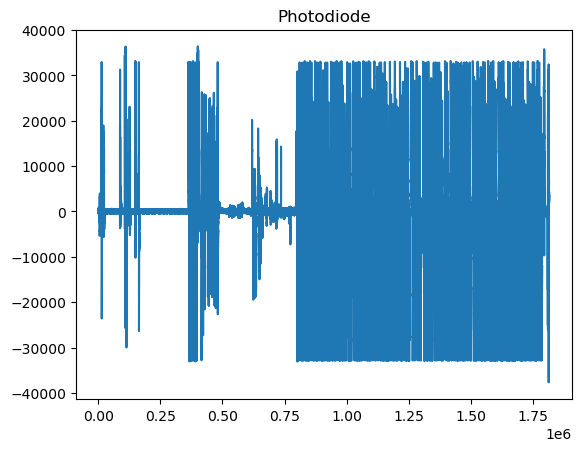

In [50]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index('photodiode')
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

Save out photodiode data (after resampling/filtering)

In [51]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='photodiode', overwrite=True)

## Add in anat recon info


In [52]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCaS1,A32sg_L,-2.954574,41.329210,4.799997,-3.150189,27.626674,-11.313929,Gray,Left ACgG anterior cingulate gyrus,Area s24,L Mid Orbital Gyrus,L CG,Left cingulate gyrus C,NaN,NaN
1,LaCaS10,A9/46d_L,-14.150090,45.726392,48.399994,-14.612690,45.647438,30.886915,White,Left Cerebral White Matter,Unknown,L Superior Frontal Gyrus,L MFG,Unknown,WM,NaN
2,LaCaS11,A9l_L,-15.349610,46.126136,53.199994,-16.068791,47.523347,35.735259,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 2 D,WM,NaN
3,LaCaS12,A9l_L,-16.149290,46.126136,57.999994,-17.096981,48.985539,40.715012,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 2 D,OOB,NaN
4,LaCaS13,Unknown,-16.948969,46.126136,63.599993,-18.060868,50.562598,46.419275,Unknown,Unknown,Unknown,L Superior Frontal Gyrus,Unknown,Left superior frontal gyrus 2 D,OOB,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,RmOlF6,A11l_R,33.430855,50.123574,8.399997,36.273305,37.087206,-11.909190,Gray,Right LOrG lateral orbital gyrus,Unknown,R IFG (p Orbitalis),R OrG,Right pars orbitalis B,WM,NaN
164,RmOlF7,A12/47o_R,37.429254,49.723831,10.399996,40.477926,37.432671,-9.831393,Gray,Right Cerebral White Matter,Unknown,R IFG (p Orbitalis),R OrG,Right pars orbitalis B,NaN,NaN
165,RmOlF8,A12/47l_R,42.227333,49.723831,12.399996,45.600992,38.133258,-7.732312,Gray,Right OrIFG orbital part of the inferior front...,Unknown,R IFG (p Orbitalis),R OrG,Right anterior pars triangularis A,NaN,NaN
166,RmOlF9,A45r_R,46.625571,49.723831,14.799996,50.223671,38.960073,-5.163690,Gray,Right TrIFG triangular part of the inferior fr...,Unknown,R IFG (p Orbitalis),R IFG,Right anterior pars triangularis A,NaN,NaN


In [53]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['rcmsp16', 'rcmsp15', 'lcmsp15', 'lcmsp16', 'photodiode']


In [54]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)




In [55]:
unmatched_names

['uraglt', 'ulhplt', 'ulmolf', 'urmolf']

In [56]:
unmatched_seeg

[]

In [57]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 84 left sEEG and 84 right sEEG electrodes
We have a total of 168 sEEG electrodes


In [58]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'photodiode':'stim'}
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawArray | 169 x 1815856 (3631.7 s), ~2.29 GB, data loaded>

In [59]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawArray | 169 x 1815856 (3631.7 s), ~2.29 GB, data loaded>

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [60]:
bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
mne_data.info['bads'] = bads

In [61]:
bads

['laglt1',
 'lhplt5',
 'lhplt8',
 'lhtoc16',
 'lmcms2',
 'lmcms4',
 'lmcms5',
 'lmolf1',
 'lmolf8',
 'rcmsp5',
 'rhplt2',
 'rhplt6',
 'rmcms8']

In [62]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [63]:
probe_names

array(['lacas', 'laglt', 'lcmsp', 'lhplt', 'lhtoc', 'lmcms', 'lmolf',
       'racas', 'raglt', 'rcmsp', 'rhplt', 'rhtoc', 'rmcms', 'rmolf',
       'ulhplt', 'ulmolf', 'uraglt', 'urmolf'], dtype='<U6')

In [64]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [65]:
probe_ch_counts

{'lacas': 14,
 'laglt': 9,
 'lcmsp': 14,
 'lhplt': 10,
 'lhtoc': 16,
 'lmcms': 10,
 'lmolf': 9,
 'racas': 14,
 'raglt': 9,
 'rcmsp': 14,
 'rhplt': 10,
 'rhtoc': 16,
 'rmcms': 10,
 'rmolf': 9,
 'ulhplt': 1,
 'ulmolf': 1,
 'uraglt': 1,
 'urmolf': 1}

<IPython.core.display.Javascript object>


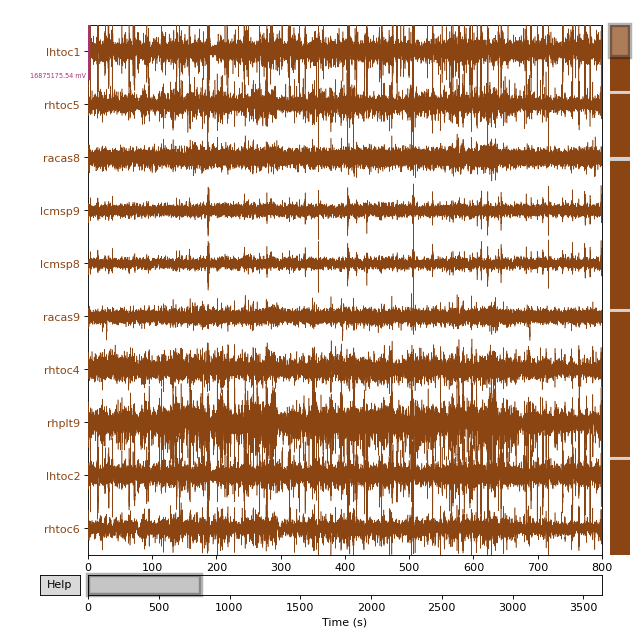

<IPython.core.display.Javascript object>


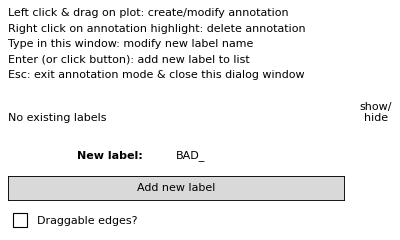

In [68]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=800, n_channels=10, scalings=mne_data._data.max()/5)
fig.fake_keypress('a')

In [69]:
mne_data.info['bads']

['lmcms8', 'laglt5', 'lacas11', 'lhplt1']

In [70]:
##save info in SWB_electrode_info spreadsheet!
bad_ch = ['lmcms8', 'laglt5', 'lacas11', 'lhplt1']

In [71]:
mne_data.info['bads'] = bad_ch

In [72]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 4 items (lmcms8, laglt5, lacas11, lhplt1)
 ch_names: lhtoc1, rhtoc5, racas8, lcmsp9, lcmsp8, racas9, rhtoc4, rhplt9, ...
 chs: 168 sEEG
 custom_ref_applied: False
 dig: 164 items (164 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 168
 projs: []
 sfreq: 500.0 Hz
>

### Rereference data to wm electrodes

In [73]:
unmatched_seeg = [] #need this to run script, also need site = 'MSSM' because davis site specificity hasn't been implemented yet 

In [74]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [75]:
oob_channels

['lacas13',
 'lacas14',
 'lhplt10',
 'lhplt9',
 'lhtoc16',
 'lmcms10',
 'racas12',
 'racas13',
 'racas14',
 'rhtoc16',
 'rmcms10']

In [76]:
#need to distinguish between wm channels and oob channels 

#add oob channels to bad channels list
bad_ch = bad_ch + oob_channels
bad_ch = list(np.unique(bad_ch))
mne_data.info['bads'] = bad_ch

In [77]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['lacas11',
 'lacas13',
 'lacas14',
 'laglt5',
 'lhplt1',
 'lhplt10',
 'lhplt9',
 'lhtoc16',
 'lmcms10',
 'lmcms8',
 'racas12',
 'racas13',
 'racas14',
 'rhtoc16',
 'rmcms10']

In [78]:
mne_data.save(f'{neural_dir}{subj_id}/lfp_data.fif',overwrite=True)

In [79]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [48]:
mne_data_reref

<RawArray | 131 x 1269504 (2539.0 s), ~1.24 GB, data loaded>

In [80]:
mne_data_reref.save(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif',overwrite=True)